# Global Overturning Streamfunction

This script plots: 
* the global overturning streamfunction in density space over a given time interval for several different ACCESS-OM2 simulations;
* the 40°S abyssal overturning timeseries for the full simulations; and
* The AMOC at 26°N (in density space) for the full simulations.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import IPython.display
import cmocean as cm

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:44189 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


In [3]:
expts = ['01deg_jra55v13_ryf9091','01deg_jra55_SAMextr_1011_from9091_kial',
        '01deg_jra55_SAMextr_9899_from9091','01deg_jra55_SAMextr_0203_from9091',
        '01deg_jra55_SAMextr_9192_from9091']
session = cc.database.create_session()

This function plots the streamfunction.

In [4]:
def plot_psi(psi_avg, clev=np.arange(-25,25,2)):

    p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=cm.cm.delta,levels=clev,extend='both')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

In [5]:
%%time
results = []
for expt in expts:
    print(expt)
    psi = cc.querying.getvar(expt,'ty_trans_rho',session)
    psi_aabw = psi.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=-40)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho').resample(time='A').mean('time').load()
    result = {'psi_aabw': psi_aabw_sum,
                  'expt': expt}
    results.append(result)
    

01deg_jra55v13_ryf9091


distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:34964 remote=tcp://127.0.0.1:44189>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:34966 remote=tcp://127.0.0.1:44189>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:34970 remote=tcp://127.0.0.1:44189>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:34972 remote=tcp://127.0.0.1:44189>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:34974 remote=tcp://127.0.0.1:44189>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:34984 remote=tcp://127.0.0.1:44189>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:34986 remote=tcp://127.0.0.1:44189>


01deg_jra55_SAMextr_1011_from9091_kial
01deg_jra55_SAMextr_9899_from9091
01deg_jra55_SAMextr_0203_from9091
01deg_jra55_SAMextr_9192_from9091
CPU times: user 16min 44s, sys: 24.5 s, total: 17min 9s
Wall time: 21min 55s


Text(0.5,1,'AABW Overturning Cell at 40°S')

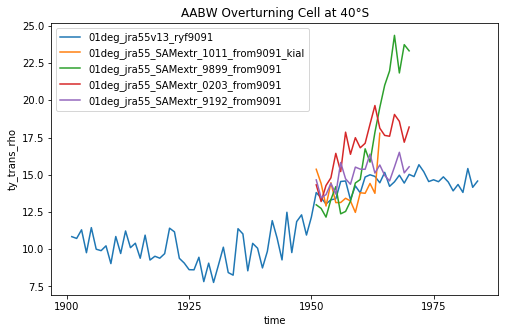

In [6]:
plt.figure(figsize=(8,5))
for result in results:
    psi_aabw = result['psi_aabw']
    expt = result['expt']
    psi_aabw.plot(label=expt)
    
plt.legend()
plt.title('AABW Overturning Cell at 40°S')

In [7]:
%%time
results = []
for expt in expts:
    print(expt)
    psi = cc.querying.getvar(expt,'ty_trans_rho',session)
    psi_amoc = psi.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho').resample(time='A').mean('time')
    result = {'psi_amoc': psi_amoc_sum,
                  'expt': expt}
    results.append(result)

01deg_jra55v13_ryf9091
01deg_jra55_SAMextr_1011_from9091_kial
01deg_jra55_SAMextr_9899_from9091
01deg_jra55_SAMextr_0203_from9091
01deg_jra55_SAMextr_9192_from9091
CPU times: user 20.6 s, sys: 1.24 s, total: 21.9 s
Wall time: 44.9 s


Text(0.5,1,'AMOC Overturning')

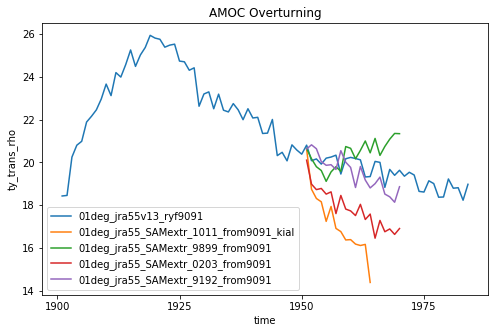

In [8]:
plt.figure(figsize=(8,5))
for result in results:
    psi_amoc = result['psi_amoc']
    expt = result['expt']
    psi_amoc.plot(label=expt)
    
plt.legend()
plt.title('AMOC Overturning')

In [9]:
%%time
results = []
for expt in expts:
    print(expt)
    psi = cc.querying.getvar(expt,'ty_trans_rho',session,start_time='1955-01-01', end_time='1960-01-01')
    psi = psi.mean('time').sum('grid_xt_ocean')*1.0e-9
    psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
    psi_avg.load()
    result = {'psi_avg': psi_avg,
                  'expt': expt}
    results.append(result)

01deg_jra55v13_ryf9091
01deg_jra55_SAMextr_1011_from9091_kial
01deg_jra55_SAMextr_9899_from9091
01deg_jra55_SAMextr_0203_from9091
01deg_jra55_SAMextr_9192_from9091
CPU times: user 22min 11s, sys: 31.5 s, total: 22min 42s
Wall time: 34min 23s


And here is the code to make the actual figure.

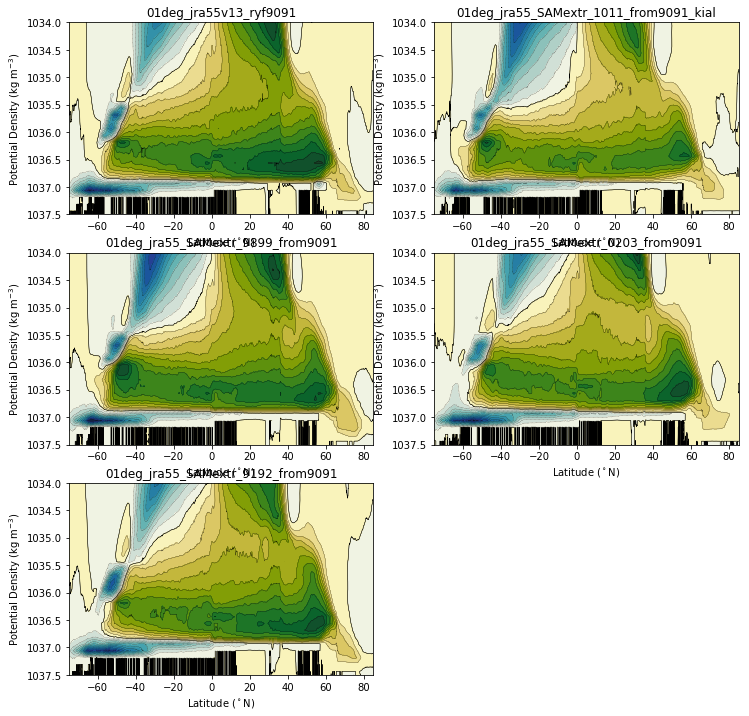

In [10]:
plt.figure(figsize=(12,12))
clev=np.arange(-26,26.01,2)
ii=1
for result in results:
    psi_avg = result['psi_avg']
    expt = result['expt']
    plt.subplot(3,2,ii)
    p1 = plot_psi(psi_avg,clev)
    plt.title(expt)
    ii+=1
    